**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [32]:
#Libraries needed for the assignment

from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

import nsfg
import survival

from collections import Counter

In [33]:
#Using NSFG respondent file for age at first marriage
resp6 = nsfg.ReadFemResp()

#Dataset for resp7 -- respondent file from 2010
resp7 = survival.ReadFemResp2010()

In [42]:
#Cleaning the respondent data
#Removing NA values and creating variables for divorce information
#Creating correct date values & getting decades for grouping
def CleanData(resp):
    """Cleans respondent data.
    resp: DataFrame
    """
    #Replace NA values for date of divorce field
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    #If not divorced, date of divorce field (cmdivorcx) is null
    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    #Duration -- subtracting date of divorce from date of marriage and dividing by 12 for years
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    #Duration so far -- subtracting current time from date of marriage
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    #Getting decades for groups
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [43]:
#Two resp dataframes & extracting the people who are married
CleanData(resp6)
married6 = resp6[resp6.evrmarry==1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry==1]

#cmdivorcx -- date of divorce for the respondent's first marriage, encoded in century-months

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

In [44]:
#This function will estimate the hazard and survival curve for the duration of marriage
def EstimateSurvivalDivorce(resp):
    """Estimates the hazard & survival curve for duration of marriage.
    resp: DataFrame of respondents
    returns: pair of HazardFunction, SurvivalFunction
    """
    
    #resp.notdivorced == 0, ended in divroce
    #resp.notdivorced ==1, marriages that are ongoing
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    #Estimate hazard and survival curves
    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

In [46]:
#Resampling the dataframes
#Take into account sampling weights
def ResampleDivorceCurve(resps):
    """Plots divorce curves based on resampled data.
    resps: list of respondent DataFrames
    """
    
    #Generating samples
    for _ in range(11):
        #Sampling weights
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        #Creating one sample out of various samples
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color='#225EA8', alpha=0.1)

    thinkplot.Show(xlabel='years',
                   axis=[0, 28, 0, 1])

In [47]:
def ResampleDivorceCurveByDecade(resps):
    """Plots divorce curves for each birth cohort.
    resps: list of respondent DataFrames    
    """
    #Same resampling method as above but for groups by decade of birth 
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel='Years',
                     ylabel='Fraction undivorced',
                     axis=[0, 28, 0, 1])

In [48]:
#Functions from Ch.13 code 
#Updated EstimateSurvivalByDecade to use the created EstimateSurvivalDivorce function

def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.
    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = '%d0s' % name
        thinkplot.Plot([15], [1], label=label, **options)

def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves for the duration of marriage in each group.
    groups: GroupBy object
    """
    
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateSurvivalDivorce(group)
        thinkplot.Plot(sf, **options)

def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.
    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')

        if omit:
            groups = [(name, group) for name, group in groups 
                      if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

In [49]:
resps = [married6, married7]

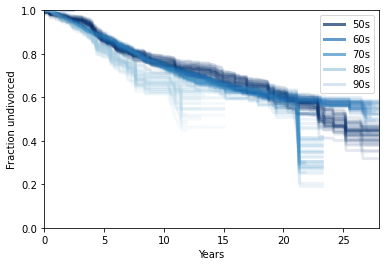

In [50]:
ResampleDivorceCurveByDecade(resps)